Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

### Neural networks

Here we have pseudocode to train an LSTM in Keras.

In [ ]:
X = #INPUT DATA
y = #LABELS

n, n_feats = X.shape
n_train = int(0.8 * len(X))
n_valid = int(0.1 * len(X))
n_test  = int(0.1 * len(X))

in_rescale = MinMaxScaler(feature_range=(-0.5, 0.5))
out_rescale = MinMaxScaler(feature_range=(-0.5, 0.5))

train_np = (in_rescale.fit_transform(X[:n_train])[None, ...],
            out_rescale.fit_transform(y[:n_train, None])[None, ...])
valid_np = (in_rescale.transform(X[n_train:n_train+n_valid])[None, ...],
            out_rescale.transform(y[n_train:n_train+n_valid, None])[None, ...])
test_np  = (in_rescale.transform(X[-n_test:])[None, ...],
            out_rescale.transform(y[-n_test:, None])[None, ...])

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=512,
                                        batch_input_shape=(1, train_np[0].shape[1], n_feats),
                                        return_sequences=True,
                                        stateful=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128,
                                        # batch_input_shape=(1, train_np[0].shape[1], 1),
                                        return_sequences=True,
                                        stateful=True)))

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='swish'))
model.add(tf.keras.layers.Dense(1))

model.build(input_shape=(1, train_np[0].shape[1], n_feats))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (1, 166062, 1024)         2166784   
_________________________________________________________________
bidirectional_2 (Bidirection (1, 166062, 256)          1180672   
_________________________________________________________________
dropout (Dropout)            (1, 166062, 256)          0         
_________________________________________________________________
dense_2 (Dense)              (1, 166062, 64)           16448     
_________________________________________________________________
dense_3 (Dense)              (1, 166062, 1)            65        
Total params: 3,363,969
Trainable params: 3,363,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_np[0],
                    train_np[1],
                    epochs=20,
                    batch_size=1,
                    validation_data=valid_np,
                    callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

train_preds = model.predict(train_np[0], batch_size=1).reshape(-1)
valid_preds = model.predict(valid_np[0], batch_size=1).reshape(-1)
test_preds  = model.predict(test_np[0], batch_size=1).reshape(-1)

train_preds_rs = out_rescale.inverse_transform(train_preds[:, None]).reshape(-1)
valid_preds_rs = out_rescale.inverse_transform(valid_preds[:, None]).reshape(-1)
test_preds_rs  = out_rescale.inverse_transform(test_preds[:, None]).reshape(-1)

With some example data, training error can be visualized as follows.

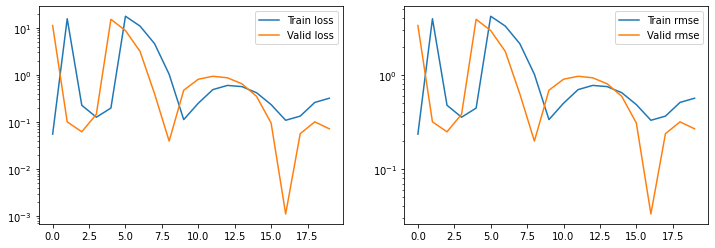

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.semilogy(history.history['loss'], label='Train loss')
plt.semilogy(history.history['val_loss'], label='Valid loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.semilogy(history.history['root_mean_squared_error'], label='Train rmse')
plt.semilogy(history.history['val_root_mean_squared_error'], label='Valid rmse')
plt.legend()
plt.show()